In [2]:
import numpy as np 
import pandas as pd 

#  **Problem Statement**

The data set is related to a meal delivery company which operates in multiple cities. They have various fulfilment centers in these cities for dispatching meal orders to their customers.
The dataset consists of historical data of demand for a product-center combination for weeks 1 to 145.
With the given data and information, the task is to predict the demand for the next 10 weeks (Weeks: 146-155) for the center-meal combinations, so that these fulfilment centers stock the necessary raw materials accordingly.

# ****Business Benefits****
The replenishment of raw materials is done only on weekly basis and since the raw material is perishable, the procurement planning is of utmost importance.
Therefore predicting the Demand helps in reducing the wastage of raw materials which would result in the reduced cost of operation. Increased customer satisfaction by timely fulfilling their expectations and requirements.



# **Libraries Used**

pandas, numpy, scikit learn, matplotlib, seaborn, xgboost, lightgbm, catboost




# **Evaluation Metric**

The evaluation metric for this competition is 100*RMSLE where RMSLE is Root of Mean Squared Logarithmic Error across all entries in the test set.

In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)  
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline 
import seaborn as sns
import plotly.io as pio
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [4]:
data=pd.read_csv('train.csv')
center=pd.read_csv('fulfilment_center_info.csv')
meal=pd.read_csv('meal_info.csv')
test=pd.read_csv('test.csv')


**Data Preprocessing**

In [5]:
print("The Shape of Demand dataset :",data.shape)
print("The Shape of Fulmilment Center Information dataset :",center.shape)
print("The Shape of Meal information dataset :",meal.shape)
print("The Shape of Test dataset :",test.shape)


The Shape of Demand dataset : (456548, 9)
The Shape of Fulmilment Center Information dataset : (77, 5)
The Shape of Meal information dataset : (51, 3)
The Shape of Test dataset : (32573, 8)


In [6]:
data.head()


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [7]:
test['num_orders']=123456 ### Assigning random number for Target Variable of Test Data.


In [8]:
test.head()


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1028232,146,55,1885,158.11,159.11,0,0,123456
1,1127204,146,55,1993,160.11,159.11,0,0,123456
2,1212707,146,55,2539,157.14,159.14,0,0,123456
3,1082698,146,55,2631,162.02,162.02,0,0,123456
4,1400926,146,55,1248,163.93,163.93,0,0,123456


In [9]:
center.head()


,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [10]:
meal.head()


,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [11]:
data=pd.concat([data,test],axis=0)


In [12]:
data=data.merge(center,on='center_id',how='left')


In [13]:
data=data.merge(meal,on='meal_id',how='left')


In [14]:
data.isnull().sum()


id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
city_code                0
region_code              0
center_type              0
op_area                  0
category                 0
cuisine                  0
dtype: int64

**Deriving New Features**

In [15]:
#Discount Amount
data['discount amount']=data['base_price']-data['checkout_price']

#Discount Percent
data['discount percent'] = ((data['base_price']-data['checkout_price'])/data['base_price'])*100

#Discount Y/N
data['discount y/n'] = [1 if x>0 else 0 for x in (data['base_price']-data['checkout_price'])]

data=data.sort_values(['center_id', 'meal_id', 'week']).reset_index()

#Compare Week Price
data['compare_week_price'] = data['checkout_price'] - data['checkout_price'].shift(1)


In [16]:
data['compare_week_price'][data['week']==1]=0


In [17]:
data=data.sort_values(by='index').reset_index().drop(['level_0','index'],axis=1)


In [18]:
# Compare Week Price Y/N
data['compare_week_price y/n'] = [1 if x>0 else 0 for x in data['compare_week_price']]


In [19]:
data.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,discount amount,discount percent,discount y/n,compare_week_price,compare_week_price y/n
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai,15.46,10.151684,1,0.0,0
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,56,TYPE_C,2.0,Beverages,Thai,-1.00,-0.736214,0,0.0,0
2,1346989,1,55,2539,134.86,135.86,0,0,189,647,56,TYPE_C,2.0,Beverages,Thai,1.00,0.736052,1,0.0,0
3,1338232,1,55,2139,339.50,437.53,0,0,54,647,56,TYPE_C,2.0,Beverages,Indian,98.03,22.405321,1,0.0,0
4,1448490,1,55,2631,243.50,242.50,0,0,40,647,56,TYPE_C,2.0,Beverages,Indian,-1.00,-0.412371,0,0.0,0


In [20]:
data.isnull().sum()

id                        0
week                      0
center_id                 0
meal_id                   0
checkout_price            0
base_price                0
emailer_for_promotion     0
homepage_featured         0
num_orders                0
city_code                 0
region_code               0
center_type               0
op_area                   0
category                  0
cuisine                   0
discount amount           0
discount percent          0
discount y/n              0
compare_week_price        0
compare_week_price y/n    0
dtype: int64

**Train Test Split**

In [21]:
train=data[data['week'].isin(range(1,146))]
test=data[data['week'].isin(range(146,156))]


In [22]:
print("The Shape of Train dataset :",train.shape)
print("The Shape of Test dataset :",test.shape)


The Shape of Train dataset : (456548, 20)
The Shape of Test dataset : (32573, 20)


<AxesSubplot:>

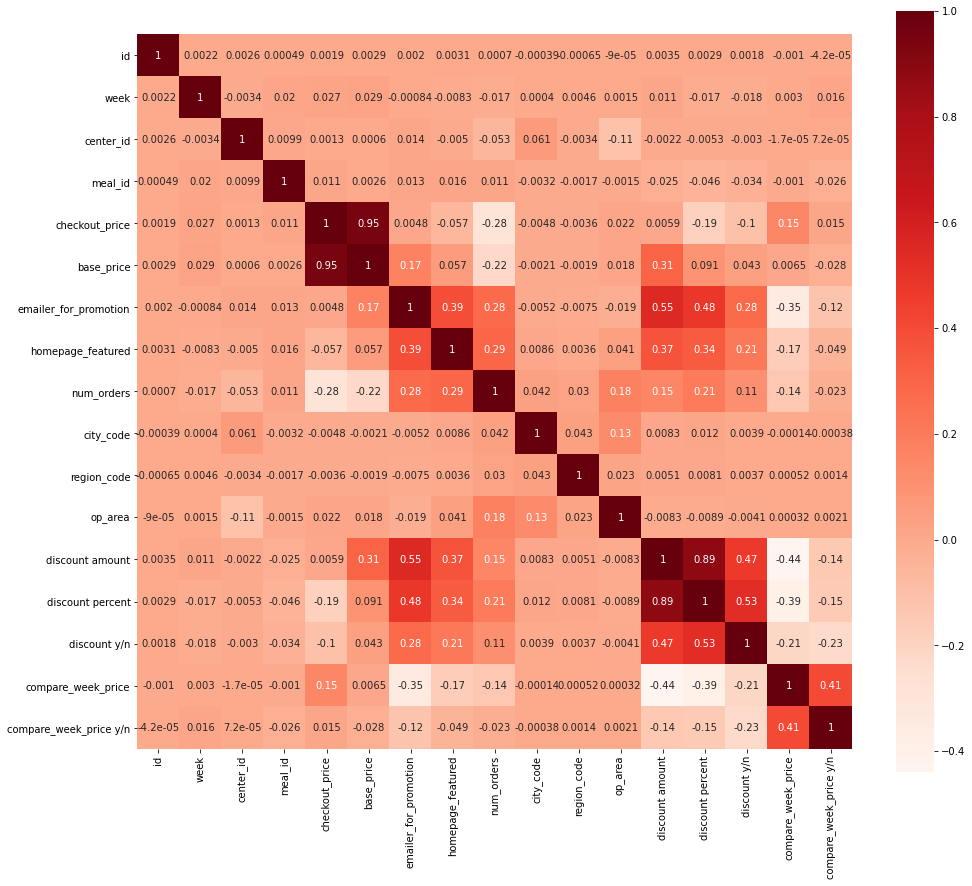

In [23]:
plt.figure(figsize=(16,14))
sns.heatmap(train.corr(),annot=True, square=True, cmap='Reds')


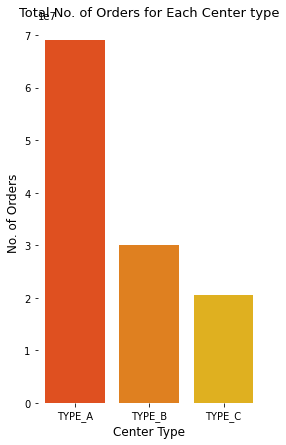

In [24]:
fig=plt.figure(figsize=(4,7))
plt.title('Total No. of Orders for Each Center type',fontdict={'fontsize':13})
sns.barplot(y='num_orders', x='center_type', data=train.groupby('center_type').sum()['num_orders'].reset_index(),palette='autumn');
plt.ylabel('No. of Orders',fontdict={'fontsize':12})
plt.xlabel('Center Type',fontdict={'fontsize':12})
sns.despine(bottom = True, left = True);


Type A has the highest number of Orders placed and Type C has lowest

In [25]:
train['center_id'].nunique()


77

The are are 77 Fullfilment Centers in total.



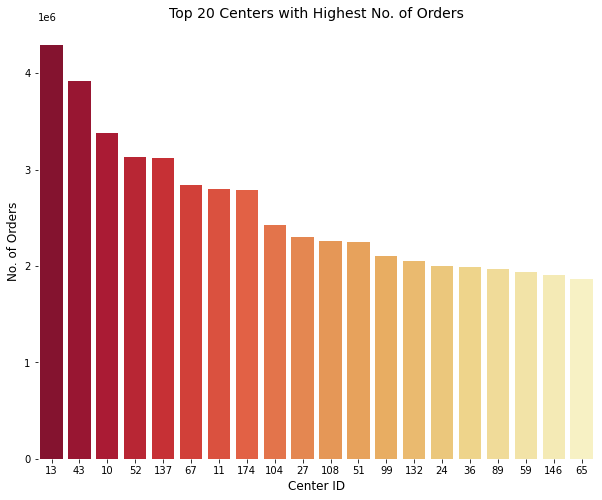

In [26]:
fig=plt.figure(figsize=(10,8))
plt.title('Top 20 Centers with Highest No. of Orders',fontdict={'fontsize':14})
sns.barplot(y='num_orders', x='center_id', data=train.groupby(['center_id','center_type']).num_orders.sum().sort_values(ascending=False).reset_index().head(20),palette='YlOrRd_r',order=list(train.groupby(['center_id','center_type']).num_orders.sum().sort_values(ascending=False).reset_index().head(20)['center_id']));
plt.ylabel('No. of Orders',fontdict={'fontsize':12})
plt.xlabel('Center ID',fontdict={'fontsize':12})
sns.despine(bottom = True, left = True);


Initially, when we checked, which Center Type has the highest number of Orders, We found that Center Type_A has the highest number of orders, but now when we check individually, we could see that Center 13 of Type_B has the highest number of Orders. Let’s analyze the reason behind that.



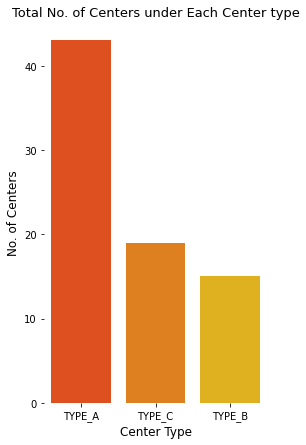

In [27]:
fig=plt.figure(figsize=(4,7))
plt.title('Total No. of Centers under Each Center type',fontdict={'fontsize':13})
sns.barplot(y=train.groupby(['center_id','center_type']).num_orders.sum().reset_index()['center_type'].value_counts(), x=train.groupby(['center_id','center_type']).num_orders.sum().reset_index()['center_type'].value_counts().index,palette='autumn');
plt.ylabel('No. of Centers',fontdict={'fontsize':12})
plt.xlabel('Center Type',fontdict={'fontsize':12})
sns.despine(bottom = True, left = True);


Type_A has the most number of orders because, Type_A has the most number of Centers - 43 Centers.



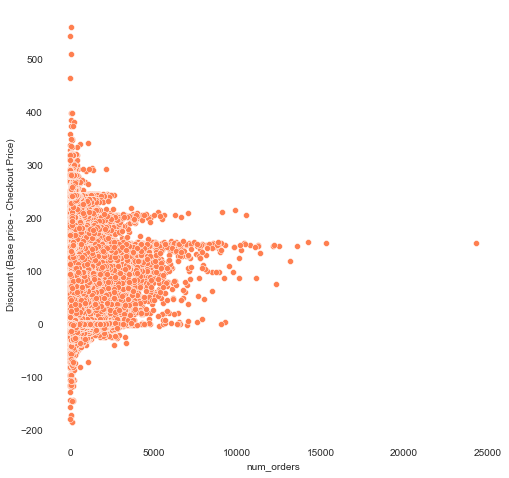

In [28]:
sns.set_style("white")
plt.figure(figsize=(8,8))
sns.scatterplot(y=train['base_price']-train['checkout_price'],x=train['num_orders'],color='coral')
plt.ylabel('Discount (Base price - Checkout Price)')
sns.despine(bottom = True, left = True)


We created a new feature: Discount which is the difference of base price and checkout price and tried to find out if there is any relationship between the discount and the number of orders. But surprisingly there are no good correlation between the discount and the number of orders.



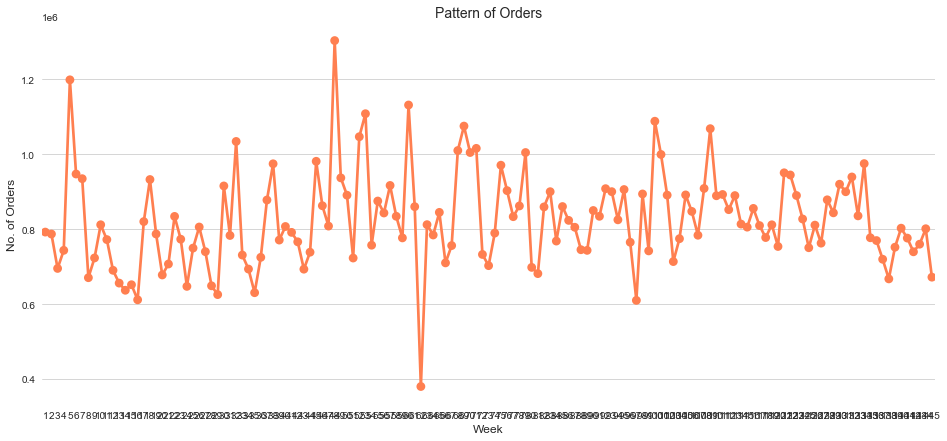

In [29]:
fig=plt.figure(figsize=(16,7))
sns.set_style("whitegrid")
plt.title('Pattern of Orders',fontdict={'fontsize':14})

sns.pointplot(x=train.groupby('week').sum().reset_index()['week'],y=train.groupby('week').sum().reset_index()['num_orders'],color='coral')
plt.ylabel('No. of Orders',fontdict={'fontsize':12})
plt.xlabel('Week',fontdict={'fontsize':12})
sns.despine(bottom = True, left = True);


When we analysed the trend of order placed over the weeks, we could see that the highest number of orders were received in week 48 and the lowest in week 62.



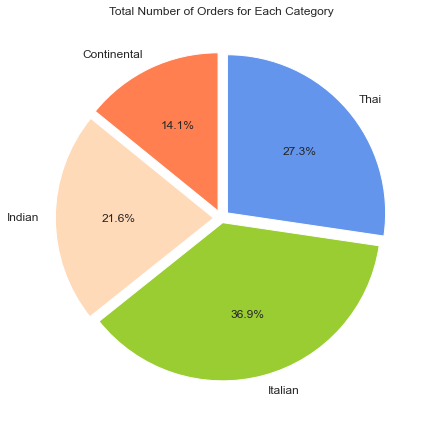

In [30]:
plt.figure(figsize=(6,6))
colors = ['coral','#FFDAB9','yellowgreen','#6495ED']
plt.pie(train.groupby(['cuisine']).num_orders.sum(),
    labels=train.groupby(['cuisine']).num_orders.sum().index,
    shadow=False,
    colors=colors,
    explode=(0.05, 0.05, 0.03,0.05),
    startangle=90, 
    autopct='%1.1f%%',pctdistance=0.6,
    textprops={'fontsize': 12})
plt.title('Total Number of Orders for Each Category')
plt.tight_layout()
plt.show()


Italian Cuisine has the highest number of orders with Continental cuisine being the least.



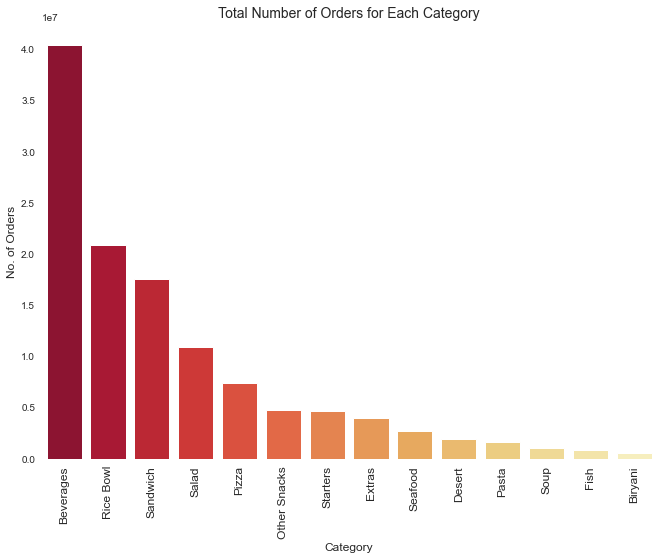

In [31]:
fig=plt.figure(figsize=(11,8))
sns.set_style("white")

plt.xticks(rotation=90,fontsize=12)
plt.title('Total Number of Orders for Each Category',fontdict={'fontsize':14})
sns.barplot(y='num_orders', x='category', data=train.groupby('category').num_orders.sum().sort_values(ascending=False).reset_index(),palette='YlOrRd_r');
plt.ylabel('No. of Orders',fontdict={'fontsize':12})
plt.xlabel('Category',fontdict={'fontsize':12})
sns.despine(bottom = True, left = True);


We could see that Beverages are the food category which has the higest number of orders and Biriyani is the food category with least number of orders.



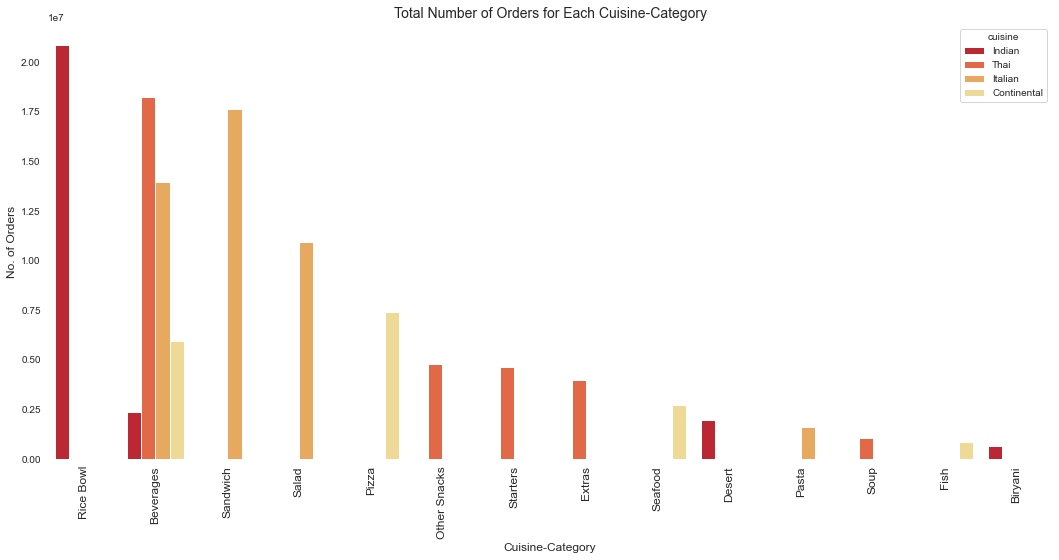

In [32]:
fig=plt.figure(figsize=(18,8))
sns.set_style("white")
plt.xticks(rotation=90,fontsize=12)
plt.title('Total Number of Orders for Each Cuisine-Category',fontdict={'fontsize':14})

sns.barplot(x='category',y='num_orders',data=train.groupby(['cuisine','category']).sum().sort_values(by='num_orders', ascending=False).reset_index(),hue='cuisine',palette='YlOrRd_r')

plt.ylabel('No. of Orders',fontdict={'fontsize':12})
plt.xlabel('Cuisine-Category',fontdict={'fontsize':12})
sns.despine(bottom = True, left = True);


Similary when we checked which specific cuisne-food category has the highest number of orders, we could see that Indian-Rice Bowl has the highest number of orders and Indian-Biriyani has the least.



In [33]:
list(data.groupby('region_code').num_orders.sum().sort_values(ascending=False).reset_index().values[:,0])


[56, 34, 77, 85, 71, 23, 93, 35]

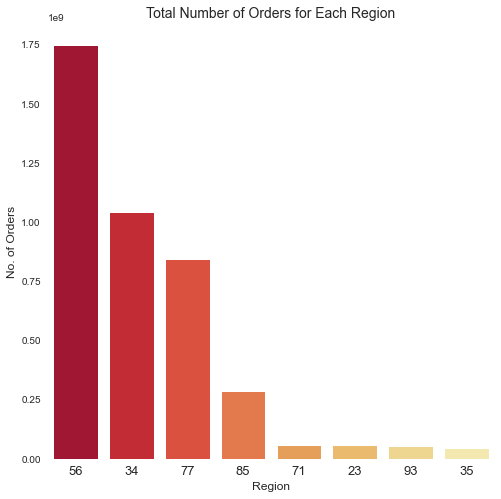

In [34]:
fig=plt.figure(figsize=(8,8))
sns.set_style("white")
plt.xticks(fontsize=13)
plt.title('Total Number of Orders for Each Region',fontdict={'fontsize':14})
sns.barplot(y='num_orders', x='region_code', data=data.groupby('region_code').num_orders.sum().sort_values(ascending=False).reset_index(),palette='YlOrRd_r',order=list(data.groupby('region_code').num_orders.sum().sort_values(ascending=False).reset_index().values[:,0]));
plt.ylabel('No. of Orders',fontdict={'fontsize':12})
plt.xlabel('Region',fontdict={'fontsize':12})
plt.xticks()
sns.despine(bottom = True, left = True);


Also when we checked the number of orders with respect to Region, we could see that Region - 56 has the highest number of orders - 60.5M orders which is almost 35M orders higher than the Region with second highest number of orders - Region 34 - 24M orders.



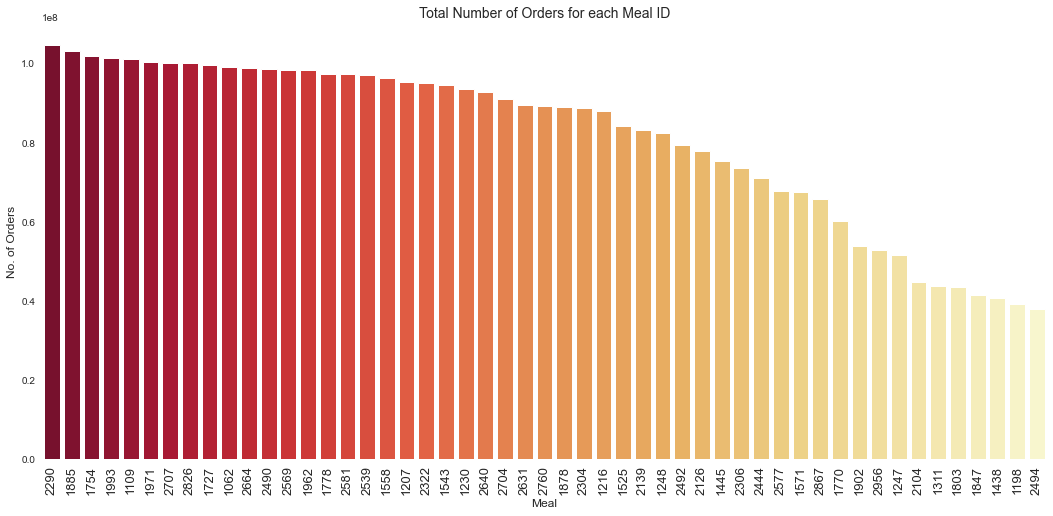

In [35]:
fig=plt.figure(figsize=(18,8))
sns.set_style("white")
plt.xticks(rotation=90,fontsize=13)
plt.title('Total Number of Orders for each Meal ID',fontdict={'fontsize':14})
sns.barplot(y='num_orders', x='meal_id', data=data.groupby('meal_id').num_orders.sum().sort_values(ascending=False).reset_index(),palette='YlOrRd_r',order=list(data.groupby('meal_id').num_orders.sum().sort_values(ascending=False).reset_index()['meal_id'].values));
plt.ylabel('No. of Orders',fontdict={'fontsize':12})
plt.xlabel('Meal',fontdict={'fontsize':12})
sns.despine(bottom = True, left = True);


Meal ID 2290 has the higest number of Orders. There is not much significant differences between number of orders for different Meal IDs.



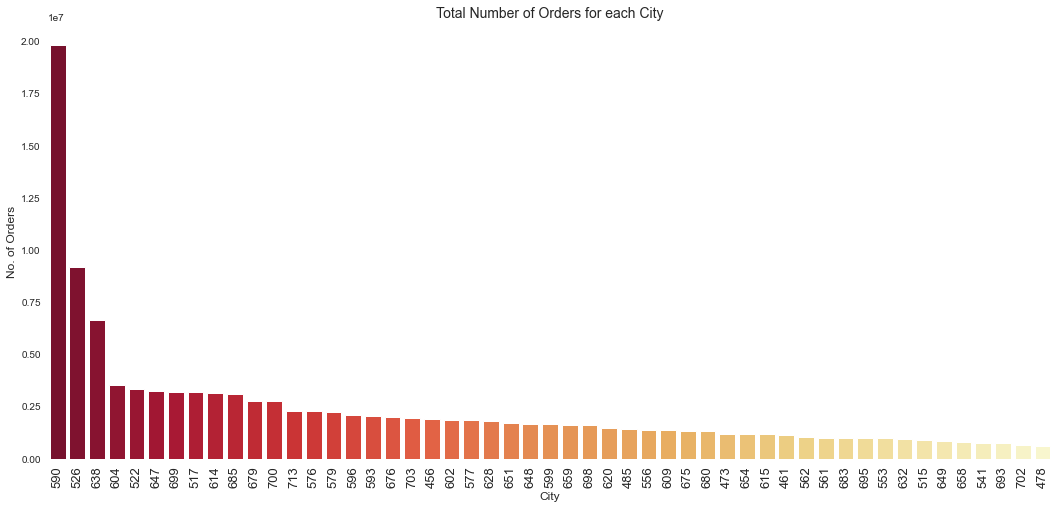

In [36]:
fig=plt.figure(figsize=(18,8))
sns.set_style("white")
plt.xticks(rotation=90,fontsize=13)
plt.title('Total Number of Orders for each City',fontdict={'fontsize':14})
sns.barplot(y='num_orders', x='city_code', data=train.groupby('city_code').num_orders.sum().sort_values(ascending=False).reset_index(),palette='YlOrRd_r',order=list(train.groupby('city_code').num_orders.sum().sort_values(ascending=False).reset_index()['city_code'].values));
plt.ylabel('No. of Orders',fontdict={'fontsize':12})
plt.xlabel('City',fontdict={'fontsize':12})
sns.despine(bottom = True, left = True);


Also when we checked the number of orders with respect to City, we could see that City - 590 has the highest number of orders - 18.5M orders which is almost 10M orders higher than the City with second highest number of orders - City 526 - 8.6M orders.



# **Encoding City**

As per our observation from our barchart of the City against the number of orders. There the high significant difference between the Top 3 cities which has the highest number of orders. Therefore, in our first approach we will encode the City with Highest No. of Orders as CH1, City with 2nd Highest No. of Orders as CH2 and City with 3rd Highest No. of Orders as CH3 and rest all of the cities which does not have much significant differences between the number of orders as CH4.



In [37]:
city4={590:'CH1', 526:'CH2', 638:'CH3'}
data['city_enc_4']=data['city_code'].map(city4)
data['city_enc_4']=data['city_enc_4'].fillna('CH4')


In [38]:
data['city_enc_4'].value_counts()


CH4    362341
CH1     58708
CH2     46589
CH3     21483
Name: city_enc_4, dtype: int64

In [39]:
data.head()


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,discount amount,discount percent,discount y/n,compare_week_price,compare_week_price y/n,city_enc_4
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai,15.46,10.151684,1,0.0,0,CH4
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,56,TYPE_C,2.0,Beverages,Thai,-1.00,-0.736214,0,0.0,0,CH4
2,1346989,1,55,2539,134.86,135.86,0,0,189,647,56,TYPE_C,2.0,Beverages,Thai,1.00,0.736052,1,0.0,0,CH4
3,1338232,1,55,2139,339.50,437.53,0,0,54,647,56,TYPE_C,2.0,Beverages,Indian,98.03,22.405321,1,0.0,0,CH4
4,1448490,1,55,2631,243.50,242.50,0,0,40,647,56,TYPE_C,2.0,Beverages,Indian,-1.00,-0.412371,0,0.0,0,CH4


In [40]:
data.isnull().sum()

id                        0
week                      0
center_id                 0
meal_id                   0
checkout_price            0
base_price                0
emailer_for_promotion     0
homepage_featured         0
num_orders                0
city_code                 0
region_code               0
center_type               0
op_area                   0
category                  0
cuisine                   0
discount amount           0
discount percent          0
discount y/n              0
compare_week_price        0
compare_week_price y/n    0
city_enc_4                0
dtype: int64

**Copying to New DataFrame**

In [41]:
datax=data.copy()
datax.head()


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,discount amount,discount percent,discount y/n,compare_week_price,compare_week_price y/n,city_enc_4
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai,15.46,10.151684,1,0.0,0,CH4
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,56,TYPE_C,2.0,Beverages,Thai,-1.00,-0.736214,0,0.0,0,CH4
2,1346989,1,55,2539,134.86,135.86,0,0,189,647,56,TYPE_C,2.0,Beverages,Thai,1.00,0.736052,1,0.0,0,CH4
3,1338232,1,55,2139,339.50,437.53,0,0,54,647,56,TYPE_C,2.0,Beverages,Indian,98.03,22.405321,1,0.0,0,CH4
4,1448490,1,55,2631,243.50,242.50,0,0,40,647,56,TYPE_C,2.0,Beverages,Indian,-1.00,-0.412371,0,0.0,0,CH4


**Encoding All Categorical Features**

In [42]:
datax['center_id']=datax['center_id'].astype('object')
datax['meal_id']=datax['meal_id'].astype('object')
datax['region_code']=datax['region_code'].astype('object')


In [43]:
obj=datax[['center_id','meal_id','region_code','center_type','category','cuisine','city_enc_4']]
num=datax.drop(['center_id','meal_id','region_code','center_type','category','cuisine','city_enc_4'],axis=1)


In [44]:
encode1=pd.get_dummies(obj,drop_first = True)


In [45]:
datax=pd.concat([num,encode1],axis=1)


In [46]:
datax.head()


,id,week,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,op_area,discount amount,discount percent,discount y/n,compare_week_price,compare_week_price y/n,center_id_11,center_id_13,center_id_14,center_id_17,center_id_20,center_id_23,center_id_24,center_id_26,center_id_27,center_id_29,center_id_30,center_id_32,center_id_34,center_id_36,center_id_39,center_id_41,center_id_42,center_id_43,center_id_50,center_id_51,center_id_52,center_id_53,center_id_55,center_id_57,center_id_58,center_id_59,center_id_61,center_id_64,center_id_65,center_id_66,center_id_67,center_id_68,center_id_72,center_id_73,center_id_74,center_id_75,center_id_76,center_id_77,center_id_80,center_id_81,center_id_83,center_id_86,center_id_88,center_id_89,center_id_91,center_id_92,center_id_93,center_id_94,center_id_97,center_id_99,center_id_101,center_id_102,center_id_104,center_id_106,center_id_108,center_id_109,center_id_110,center_id_113,center_id_124,center_id_126,center_id_129,center_id_132,center_id_137,center_id_139,center_id_143,center_id_145,center_id_146,center_id_149,center_id_152,center_id_153,center_id_157,center_id_161,center_id_162,center_id_174,center_id_177,center_id_186,meal_id_1109,meal_id_1198,meal_id_1207,meal_id_1216,meal_id_1230,meal_id_1247,meal_id_1248,meal_id_1311,meal_id_1438,meal_id_1445,meal_id_1525,meal_id_1543,meal_id_1558,meal_id_1571,meal_id_1727,meal_id_1754,meal_id_1770,meal_id_1778,meal_id_1803,meal_id_1847,meal_id_1878,meal_id_1885,meal_id_1902,meal_id_1962,meal_id_1971,meal_id_1993,meal_id_2104,meal_id_2126,meal_id_2139,meal_id_2290,meal_id_2304,meal_id_2306,meal_id_2322,meal_id_2444,meal_id_2490,meal_id_2492,meal_id_2494,meal_id_2539,meal_id_2569,meal_id_2577,meal_id_2581,meal_id_2631,meal_id_2640,meal_id_2664,meal_id_2704,meal_id_2707,meal_id_2760,meal_id_2826,meal_id_2867,meal_id_2956,region_code_34,region_code_35,region_code_56,region_code_71,region_code_77,region_code_85,region_code_93,center_type_TYPE_B,center_type_TYPE_C,category_Biryani,category_Desert,category_Extras,category_Fish,category_Other Snacks,category_Pasta,category_Pizza,category_Rice Bowl,category_Salad,category_Sandwich,category_Seafood,category_Soup,category_Starters,cuisine_Indian,cuisine_Italian,cuisine_Thai,city_enc_4_CH2,city_enc_4_CH3,city_enc_4_CH4
0,1379560,1,136.83,152.29,0,0,177,647,2.0,15.46,10.151684,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,1466964,1,136.83,135.83,0,0,270,647,2.0,-1.00,-0.736214,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
2,1346989,1,134.86,135.86,0,0,189,647,2.0,1.00,0.736052,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,1338232,1,339.50,437.53,0,0,54,647,2.0,98.03,22.405321,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
4,1448490,1,243.50,242.50,0,0,40,647,2.0,-1.00,-0.412371,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

# **Base Model**

Building base model by splitting the last 10 week of the train dataset as test.


In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


In [48]:
train=datax[datax['week'].isin(range(1,136))]
test=datax[datax['week'].isin(range(136,146))]

X_train=train.drop(['id','num_orders','week'],axis=1)
y_train=train['num_orders']

X_test=test.drop(['id','num_orders','week'],axis=1)
y_test=test['num_orders']

reg = LinearRegression()
reg.fit(X_train,y_train)
print('Train Score :',reg.score(X_train,y_train))
print('Test Score :',reg.score(X_test,y_test))

y_pred = reg.predict(X_test)
print('R squared :',(r2_score(y_test,y_pred)))
print('RMSE :',np.sqrt(mean_squared_error(y_test,y_pred)))


Train Score : 0.4928513402916549
Test Score : 0.5062932614085812
R squared : 0.5062932614085812
RMSE : 194.3465209045031


Linear Model 2 : Applying Standard Scaling & Log Transformation


In [49]:
sc=StandardScaler()

cat=datax.drop(['checkout_price','base_price','discount amount','discount percent','compare_week_price'],axis=1)
num=datax[['checkout_price','base_price','discount amount','discount percent','compare_week_price']]
scal= pd.DataFrame(sc.fit_transform(num),columns=num.columns)
datas=pd.concat([scal,cat],axis=1)

train=datas[datas['week'].isin(range(1,136))]
test=datas[datas['week'].isin(range(136,146))]


X_train=train.drop(['id','num_orders','week'],axis=1)
y_train=np.log(train['num_orders']) #Applying Log Transformation on the Target Feature

X_test=test.drop(['id','num_orders','week'],axis=1)
y_test=np.log(test['num_orders']) #Applying Log Transformation on the Target Feature

reg = LinearRegression()
reg.fit(X_train,y_train)
print('Train Score :',reg.score(X_train,y_train))
print('Test Score :',reg.score(X_test,y_test))

y_pred = reg.predict(X_test)
print('R squared :',(r2_score(y_test,y_pred)))
print('RMSLE :',np.sqrt(mean_squared_error(y_test,y_pred)))


Train Score : 0.7273897673333798
Test Score : 0.7032174789754272
R squared : 0.7032174789754272
RMSLE : 0.6347859384596506


**Copying to New DataFrame**

In [53]:
datay=datas.copy()


In [54]:
datay['Quarter']=(datas['week']/13).astype('int64')


In [55]:
datay['Quarter'] = datay['Quarter'].map({0:'Q1',
                         1:'Q2',
                         2:'Q3',
                         3:'Q4',
                         4:'Q1',
                         5:'Q2',
                         6:'Q3',
                         7:'Q4',
                         8:'Q1',
                         9:'Q2',
                         10:'Q3',
                         11:'Q4'})

In [56]:
datay['Quarter'].value_counts()


Q4    124839
Q3    124225
Q2    122386
Q1    117671
Name: Quarter, dtype: int64

In [57]:
datay['Year']=(datas['week']/52).astype('int64')


In [58]:
datay['Year'] = datay['Year'].map({0:'Y1',
                         1:'Y2',
                         2:'Y3'})

In [59]:
objy=datay[['Quarter', 'Year']]
numy=datay.drop(['Quarter', 'Year'],axis=1)

encode1y=pd.get_dummies(objy,drop_first = True)
encode1y.head()

datay=pd.concat([numy,encode1y],axis=1)


In [60]:
datay.head()

,checkout_price,base_price,discount amount,discount percent,compare_week_price,id,week,emailer_for_promotion,homepage_featured,num_orders,city_code,op_area,discount y/n,compare_week_price y/n,center_id_11,center_id_13,center_id_14,center_id_17,center_id_20,center_id_23,center_id_24,center_id_26,center_id_27,center_id_29,center_id_30,center_id_32,center_id_34,center_id_36,center_id_39,center_id_41,center_id_42,center_id_43,center_id_50,center_id_51,center_id_52,center_id_53,center_id_55,center_id_57,center_id_58,center_id_59,center_id_61,center_id_64,center_id_65,center_id_66,center_id_67,center_id_68,center_id_72,center_id_73,center_id_74,center_id_75,center_id_76,center_id_77,center_id_80,center_id_81,center_id_83,center_id_86,center_id_88,center_id_89,center_id_91,center_id_92,center_id_93,center_id_94,center_id_97,center_id_99,center_id_101,center_id_102,center_id_104,center_id_106,center_id_108,center_id_109,center_id_110,center_id_113,center_id_124,center_id_126,center_id_129,center_id_132,center_id_137,center_id_139,center_id_143,center_id_145,center_id_146,center_id_149,center_id_152,center_id_153,center_id_157,center_id_161,center_id_162,center_id_174,center_id_177,center_id_186,meal_id_1109,meal_id_1198,meal_id_1207,meal_id_1216,meal_id_1230,meal_id_1247,meal_id_1248,meal_id_1311,meal_id_1438,meal_id_1445,meal_id_1525,meal_id_1543,meal_id_1558,meal_id_1571,meal_id_1727,meal_id_1754,meal_id_1770,meal_id_1778,meal_id_1803,meal_id_1847,meal_id_1878,meal_id_1885,meal_id_1902,meal_id_1962,meal_id_1971,meal_id_1993,meal_id_2104,meal_id_2126,meal_id_2139,meal_id_2290,meal_id_2304,meal_id_2306,meal_id_2322,meal_id_2444,meal_id_2490,meal_id_2492,meal_id_2494,meal_id_2539,meal_id_2569,meal_id_2577,meal_id_2581,meal_id_2631,meal_id_2640,meal_id_2664,meal_id_2704,meal_id_2707,meal_id_2760,meal_id_2826,meal_id_2867,meal_id_2956,region_code_34,region_code_35,region_code_56,region_code_71,region_code_77,region_code_85,region_code_93,center_type_TYPE_B,center_type_TYPE_C,category_Biryani,category_Desert,category_Extras,category_Fish,category_Other Snacks,category_Pasta,category_Pizza,category_Rice Bowl,category_Salad,category_Sandwich,category_Seafood,category_Soup,category_Starters,cuisine_Indian,cuisine_Italian,cuisine_Thai,city_enc_4_CH2,city_enc_4_CH3,city_enc_4_CH4,Quarter_Q2,Quarter_Q3,Quarter_Q4,Year_Y2,Year_Y3
0,-1.281184,-1.259867,-0.124498,0.399910,-0.003326,1379560,1,0,0,177,647,2.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,-1.281184,-1.362517,-0.467581,-0.562824,-0.003326,1466964,1,0,0,270,647,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2,-1.294058,-1.362329,-0.425894,-0.432643,-0.003326,1346989,1,0,0,189,647,2.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
3,0.043267,0.518969,1.596548,1.483406,-0.003326,1338232,1,0,0,54,647,2.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
4,-0.584095,-0.697293,-0.467581,-0.534189,-0.003326,1

**Applying Log Transformation on the Target Feature**

In [61]:
datay['num_orders']=np.log1p(datay['num_orders'])


In [62]:
train=datay[datay['week'].isin(range(1,146))]
def outliers_3(col):
    q3=round(train[col].quantile(0.75),6)
    q1=round(train[col].quantile(0.25),6)
    iqr=q3-q1
    lw = q1 - (3*iqr)
    hw = q3 + (3*iqr)  
    uo=train[train[col]>hw].shape[0]
    lo=train[train[col]<lw].shape[0]
    print('Number of Upper Outliers :',uo)
    print('Number of Lower Outliers :',lo)
    print('Percentage of Outliers :',((uo+lo)/train.shape[0])*100)


In [63]:

outliers_3('num_orders')


Number of Upper Outliers : 0
Number of Lower Outliers : 0
Percentage of Outliers : 0.0


In [64]:
datay.head()

,checkout_price,base_price,discount amount,discount percent,compare_week_price,id,week,emailer_for_promotion,homepage_featured,num_orders,city_code,op_area,discount y/n,compare_week_price y/n,center_id_11,center_id_13,center_id_14,center_id_17,center_id_20,center_id_23,center_id_24,center_id_26,center_id_27,center_id_29,center_id_30,center_id_32,center_id_34,center_id_36,center_id_39,center_id_41,center_id_42,center_id_43,center_id_50,center_id_51,center_id_52,center_id_53,center_id_55,center_id_57,center_id_58,center_id_59,center_id_61,center_id_64,center_id_65,center_id_66,center_id_67,center_id_68,center_id_72,center_id_73,center_id_74,center_id_75,center_id_76,center_id_77,center_id_80,center_id_81,center_id_83,center_id_86,center_id_88,center_id_89,center_id_91,center_id_92,center_id_93,center_id_94,center_id_97,center_id_99,center_id_101,center_id_102,center_id_104,center_id_106,center_id_108,center_id_109,center_id_110,center_id_113,center_id_124,center_id_126,center_id_129,center_id_132,center_id_137,center_id_139,center_id_143,center_id_145,center_id_146,center_id_149,center_id_152,center_id_153,center_id_157,center_id_161,center_id_162,center_id_174,center_id_177,center_id_186,meal_id_1109,meal_id_1198,meal_id_1207,meal_id_1216,meal_id_1230,meal_id_1247,meal_id_1248,meal_id_1311,meal_id_1438,meal_id_1445,meal_id_1525,meal_id_1543,meal_id_1558,meal_id_1571,meal_id_1727,meal_id_1754,meal_id_1770,meal_id_1778,meal_id_1803,meal_id_1847,meal_id_1878,meal_id_1885,meal_id_1902,meal_id_1962,meal_id_1971,meal_id_1993,meal_id_2104,meal_id_2126,meal_id_2139,meal_id_2290,meal_id_2304,meal_id_2306,meal_id_2322,meal_id_2444,meal_id_2490,meal_id_2492,meal_id_2494,meal_id_2539,meal_id_2569,meal_id_2577,meal_id_2581,meal_id_2631,meal_id_2640,meal_id_2664,meal_id_2704,meal_id_2707,meal_id_2760,meal_id_2826,meal_id_2867,meal_id_2956,region_code_34,region_code_35,region_code_56,region_code_71,region_code_77,region_code_85,region_code_93,center_type_TYPE_B,center_type_TYPE_C,category_Biryani,category_Desert,category_Extras,category_Fish,category_Other Snacks,category_Pasta,category_Pizza,category_Rice Bowl,category_Salad,category_Sandwich,category_Seafood,category_Soup,category_Starters,cuisine_Indian,cuisine_Italian,cuisine_Thai,city_enc_4_CH2,city_enc_4_CH3,city_enc_4_CH4,Quarter_Q2,Quarter_Q3,Quarter_Q4,Year_Y2,Year_Y3
0,-1.281184,-1.259867,-0.124498,0.399910,-0.003326,1379560,1,0,0,5.181784,647,2.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,-1.281184,-1.362517,-0.467581,-0.562824,-0.003326,1466964,1,0,0,5.602119,647,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2,-1.294058,-1.362329,-0.425894,-0.432643,-0.003326,1346989,1,0,0,5.247024,647,2.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
3,0.043267,0.518969,1.596548,1.483406,-0.003326,1338232,1,0,0,4.007333,647,2.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
4,-0.584095,-0.697293,-0.467581,

In [65]:
train=datay[datay['week'].isin(range(1,136))]
test=datay[datay['week'].isin(range(136,146))]


X_train=train.drop(['id','num_orders','week','discount amount','city_code'],axis=1)
y_train=train['num_orders']

X_test=test.drop(['id','num_orders','week','discount amount','city_code'],axis=1)
y_test=test['num_orders'] 

reg = LinearRegression()
reg.fit(X_train,y_train)
print('Train Score :',reg.score(X_train,y_train))
print('Test Score :',reg.score(X_test,y_test))

predictions = reg.predict(X_test)
print('R squared :',(r2_score(y_test,y_pred)))
print('RMSLE :',np.sqrt(mean_squared_error(y_test,y_pred)))


Train Score : 0.7290439964330694
Test Score : 0.7044809810943244
R squared : 0.7038678264978688
RMSLE : 0.6253363223064883


In [66]:
Result=pd.DataFrame(predictions)
Result=np.expm1(Result).astype('int64')
Submission = pd.DataFrame(columns=['id', 'num_orders'])
Submission['id'] = test['id']
Submission['num_orders'] = Result.values
Submission.to_csv('My submission.csv', index=False)
print("Your submission was successfully saved")


Your submission was successfully saved


In [67]:
Submission.head()

,id,num_orders
423727,1017495,245
423728,1395634,210
423729,1007493,101
423730,1042952,54
423731,1022147,44
